In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner


In [2]:
from starccato_flow.data.toy_data import ToyData
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.ccsn_snr_data import CCSNSNRData
from starccato_flow.training.trainer import Trainer

from starccato_flow.plotting.plotting import plot_reconstruction_distribution

MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

### Dataset Plots

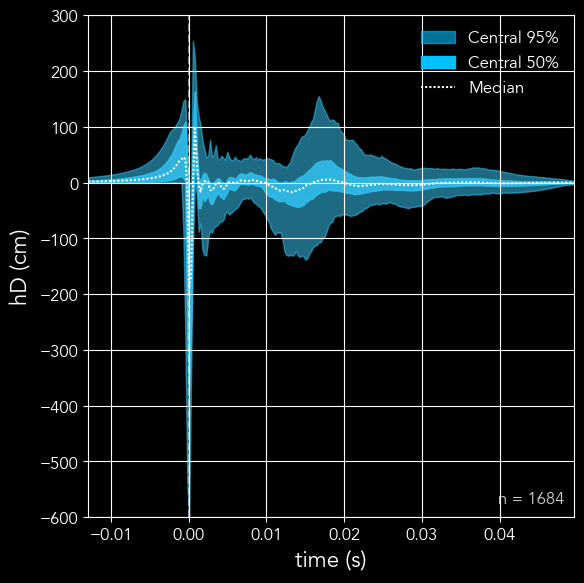

In [4]:
ccsn_dataset = CCSNSNRData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:351: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:351: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:351: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


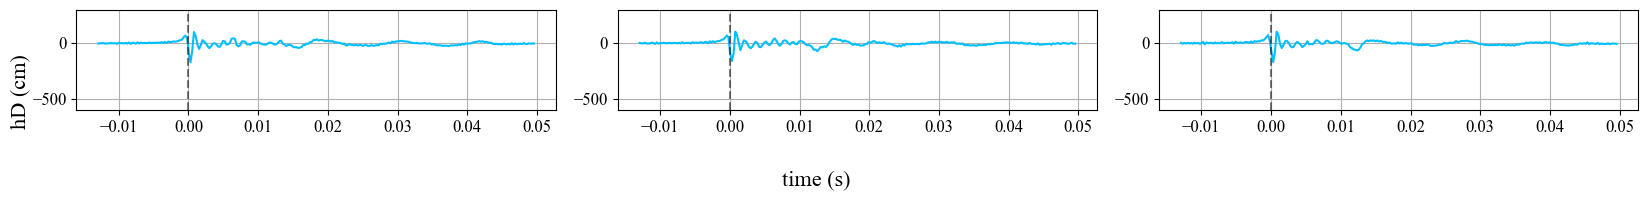

In [5]:
ccsn_dataset.update_snr(2)
ccsn_dataset.plot_signal_grid(background="white", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_grid.svg")

In [6]:
toy=False

### Train VAE + Flow

In [ ]:
# Train with 3 noise realizations = 3x more data!
# This should significantly improve validation NLL
trainer = Trainer(
    toy=toy, 
    noise=True, 
    curriculum=True,
    noise_realizations=1
)
trainer.train()


Verifying data alignment:
Number of signals: 1684
Number of parameter sets: 1684
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
   beta1_IC_b  A(km)  Ye_c_b  omega_0(rad|s)
1    0.000749    634  0.2465             0.5
2    0.002987    634  0.2465             1.0
3    0.006661    634  0.2465             1.5
4    0.011734    634  0.2465             2.0
5    0.017965    634  0.2465             2.5

Verifying data alignment:
Number of signals: 1684
Number of parameter sets: 1684
Parameter columns: ['beta1_IC_b', 'A(km)', 'Ye_c_b', 'omega_0(rad|s)']
First few parameter values:
   beta1_IC_b  A(km)  Ye_c_b  omega_0(rad|s)
1    0.000749    634  0.2465             0.5
2    0.002987    634  0.2465             1.0
3    0.006661    634  0.2465             1.5
4    0.011734    634  0.2465             2.0
5    0.017965    634  0.2465             2.5
Training samples: 1516
Validation samples: 168


Epochs:   0%|          | 0/256 [00:00<?, ?it/s]/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:364: RuntimeWarning: divide by zero encountered in power
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:364: RuntimeWarning: divide by zero encountered in divide
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_data.py:364: RuntimeWarning: invalid value encountered in subtract
  psd = 1e-49 * (pow(x, - 4.14) - 5 / x2 + 111 * (1 - x2 + 0.5 * x2 * x2) / (1 + 0.5 * x2))


### Display Results

In [ ]:
trainer.display_results()

In [ ]:
# plot_latent_morph_up_and_down(
#     trainer.vae,
#     signal_1=ccsn_dataset.__getitem__(800)[0],
#     signal_2=ccsn_dataset.__getitem__(600)[0],
#     max_value=trainer.training_dataset.max_strain,
#     train_dataset=CCSNData(),
#     steps=1
# )

In [ ]:
trainer.plot_generated_signal_distribution(
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

In [ ]:
index = 9

val_idx = trainer.validation_sampler.indices[index]
signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(val_idx)

plot_reconstruction_distribution(
    vae=trainer.vae,
    noisy_signal=noisy_signal,
    true_signal=signal,
    max_value=trainer.validation_dataset.max_strain,
    num_samples=1000,
    background="white",
    font_family="sans-serif",
    font_name="Avenir"
)

In [ ]:
trainer.save_models()

In [ ]:
trainer.plot_corner(index=100)